In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last" # all | last | last_expr | none 

In [4]:
# ============= Import required packaages ==============

# Import all custom variables and modules
from custom_classes_defs.preprocessing import *
# from custom_classes_defs.unet0 import * 
# from custom_classes_defs.Unet_like import *  
from custom_classes_defs.unet import *  
# from custom_classes_defs.fnet0 import *
# from custom_classes_defs.fnet_like import *
# from custom_classes_defs.fnet import *

RND_STATE = 247
BATCH_SIZE = 512
EPOCHS = 200
keras.utils.set_random_seed(RND_STATE)
from keras.utils import plot_model

INTERACTIVE_SESSION = True

# -------------------------------------------------------

2024-05-31 18:16:05.950496: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-31 18:16:06.490826: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-31 18:16:06.491182: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-31 18:16:06.566308: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-31 18:16:06.721720: I tensorflow/core/platform/cpu_feature_guar

In [5]:
# Verify tensorflow/keras versions
print(f"tensorflow version: {tf.__version__}")
print(f"keras version: {keras.__version__}")

# Verify CPU/GPU availability
print(tf.config.list_physical_devices())
NUM_GPU = len(tf.config.list_physical_devices('GPU'))
print(f"Number of GPUs assigned for computation: {NUM_GPU}")

if NUM_GPU:
    # print GPU info
    !nvidia-smi
    
if NUM_GPU>1:
    strategy = tf.distribute.MirroredStrategy()
    # strategy = tf.distribute.MultiWorkerMirroredStrategy()
    BATCH_SIZE = strategy.num_replicas_in_sync * BATCH_SIZE

tensorflow version: 2.15.0
keras version: 2.15.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Number of GPUs assigned for computation: 1
/usr/local/bin/bash: /opt/miniconda3-py311/lib/libtinfo.so.6: no version information available (required by /usr/local/bin/bash)


Fri May 31 18:16:39 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-PCIE-40GB          On  | 00000000:3B:00.0 Off |                    0 |
| N/A   64C    P0             209W / 250W |  39535MiB / 40960MiB |     84%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

### Data preparation and model configurations

In [6]:
print("{}\n\t{}\n{}".format('='*55,'Data preparation and model configurations', '-'*55))
# Images and annations for Thebe seismic data
start = time.time()
img_url = '../thebe_new/seismic'
target_url = '../thebe_new/fault'
seis = Thebe(img_url, target_url)
    
# Create datasets for respective data samples and labels
x_test, y_test = seis.data_generator('test', as_numpy=True)
        
print("Size of test data: {}".format(seis.test_size)) 

print('...elapsed time: ___{:5.2f} minutes___'.format((time.time()-start) / 60))

	Data preparation and model configurations
-------------------------------------------------------


Size of test data: 224122
...elapsed time: ___ 0.26 minutes___


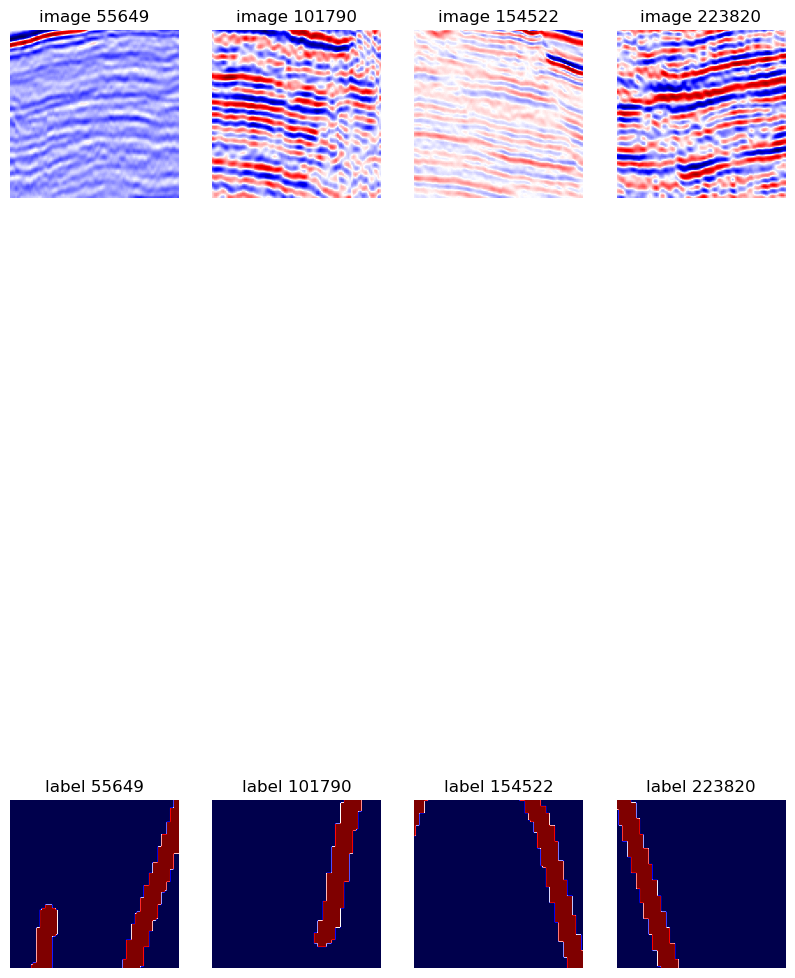

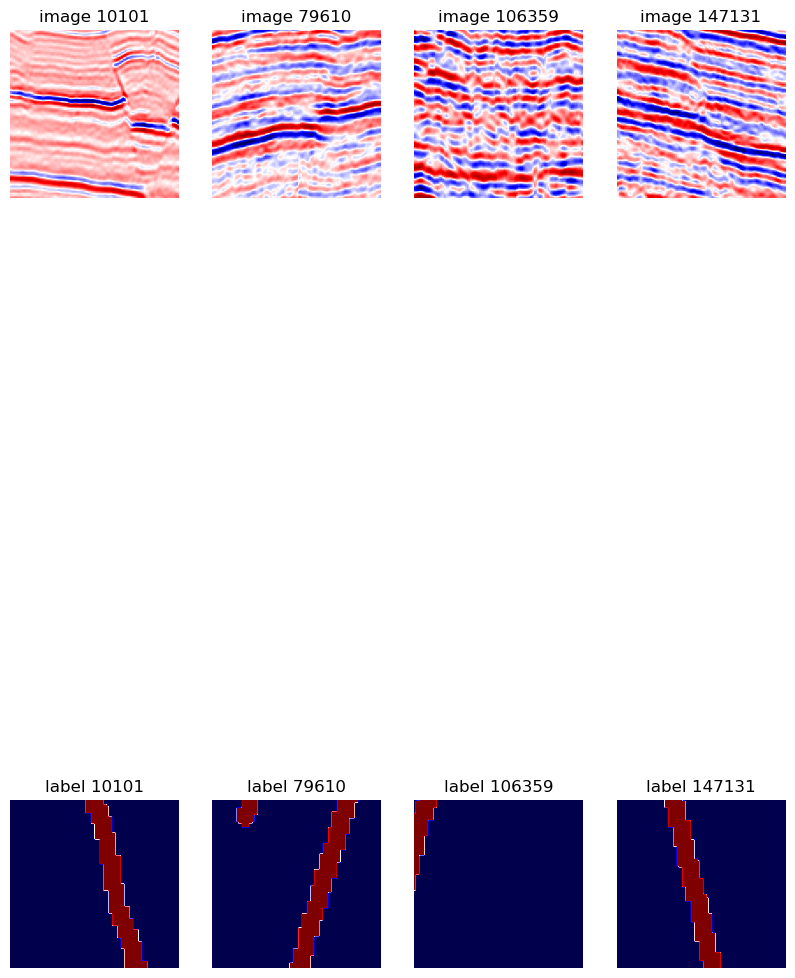

In [7]:
if INTERACTIVE_SESSION:
    seis.display_sample_images(x_test, y_test, num_images=4)
    seis.display_sample_images(x_test, y_test, num_images=4)


In [8]:
# Model configurations
conf = model_config(
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    scaling=1,
    save_path='./Thebe/unet',
    img_shape=seis.img_size,
    target_size=seis.img_size,
    threshold=seis.threshold,
    pos_label=seis.pos_label,
    train_size=seis.train_size,
    test_size=seis.test_size,
    multiple_gpu_device=(NUM_GPU>1),
    validation_size=seis.validation_size
)

assert not(conf.new_training_session)

conf.info()

             NUM_GPU: 1
        compile_args:
                     optimizer: adam
                          loss: binary_crossentropy
              labels: ListWrapper([0, 1])
     mixed_precision: None
          model_arch:
                     img_shape: (96, 96)
                   target_size: (96, 96)
                  channels_dim: (1, 1)
                       scaling: 1
                  augmentation: False
 multiple_gpu_device: False
new_training_session: False
           pos_label: 1
resume_training_session: 0
           save_path: ./Thebe/unet
           test_size: 224122
           threshold: 0.5
          train_size: None
       training_args:
                        epochs: 200
                    batch_size: 512
                       shuffle: True
                       verbose: 0
   training_duration: None
     validation_size: None


2024-05-31 18:17:11.476855: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 37787 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:5e:00.0, compute capability: 8.0


### Build  model 

In [9]:
print("\n\n{}\n\t{}\n{}".format('='*55,f'Build model', '-'*55))

if conf.multiple_gpu_device:

    print(f"Number of devices: {strategy.num_replicas_in_sync}")

m_obj = UNET2D(panel_sizes=[32,64,128,256], model_arch=conf.model_arch)
# m_obj = FNET2D(panel_sizes=[32,64,128,256], model_arch=conf.model_arch)
model = m_obj.build_model()
# model.compile(**conf.compile_args)


# model.summary()
# keras.utils.plot_model(model, 'm_obj.png',show_shapes=True)
# plot_model(model, 'm_obj.png',show_shapes=True)
num_trainable_weights = sum([np.prod(w.shape) for w in model.trainable_weights])
print(f"Total number of parameters: {model.count_params():,}")
print(f"Total trainable wieghts: {num_trainable_weights:,}")
print(f"Total non-trainable wieghts: {model.count_params()-num_trainable_weights:,}")





	Build model
-------------------------------------------------------


Total number of parameters: 1,845,409
Total trainable wieghts: 1,842,593
Total non-trainable wieghts: 2,816


### Train  model



	Train unet model
-------------------------------------------------------


model train history 'model+_history.pickle'loaded!
             NUM_GPU: 1
        compile_args:
                     optimizer: adam
                          loss: binary_crossentropy
                       metrics: accuracy
                              : f1_score(name=f1_score,dtype=float32)
              labels: ListWrapper([0, 1])
     mixed_precision: None
          model_arch:
                     img_shape: (96, 96)
                   target_size: (96, 96)
                  channels_dim: (1, 1)
                       scaling: 1
                  augmentation: False
 multiple_gpu_device: False
new_training_session: True
           pos_label: 1
           save_path: ./Thebe/unet
           test_size: 66077
           threshold: 0.5
          train_size: 181029
       training_args:
                        epochs: 100
                    batch_size: 256
                       shuffle: True
                       verbose: 0
               validation_data: <class 'tensorflow.python

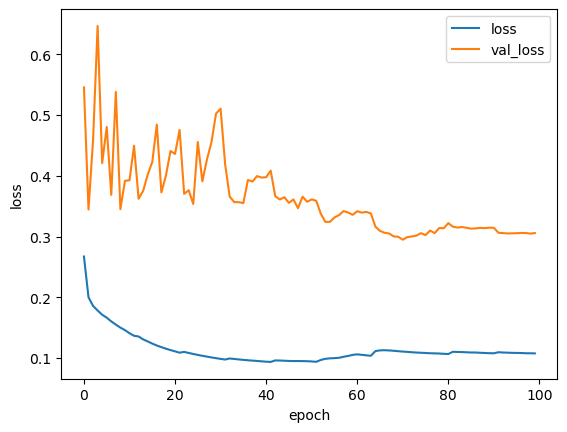

In [10]:
print("\n\n{}\n\t{}\n{}".format('='*55,f'Train {m_obj.Name} model', '-'*55))

model, train_history = \
    conf.execute_training(
        model, 
        data=None, 
        plot_history=INTERACTIVE_SESSION
)


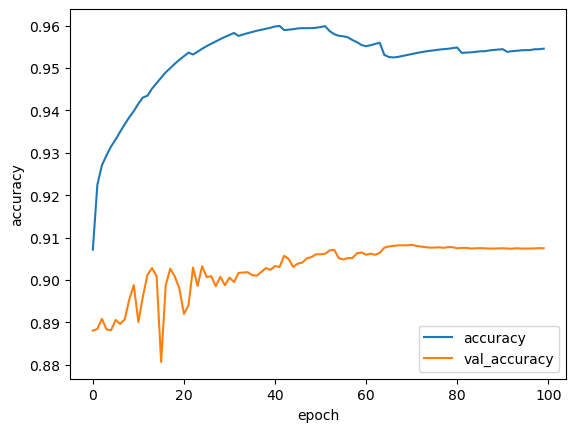

In [11]:
if INTERACTIVE_SESSION:
    show_convergence(train_history.history, ['accuracy','val_accuracy'])

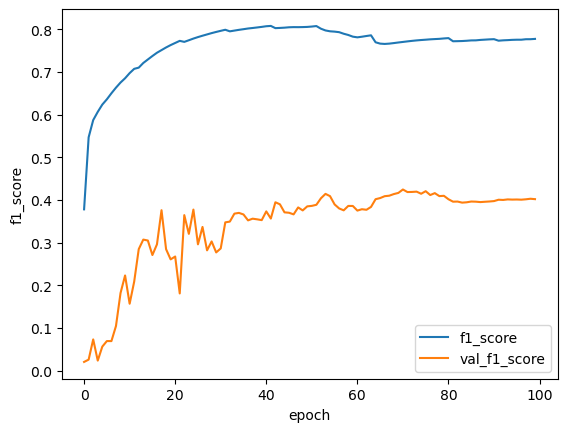

In [12]:
if INTERACTIVE_SESSION:
    show_convergence(train_history.history, ['f1_score','val_f1_score'])

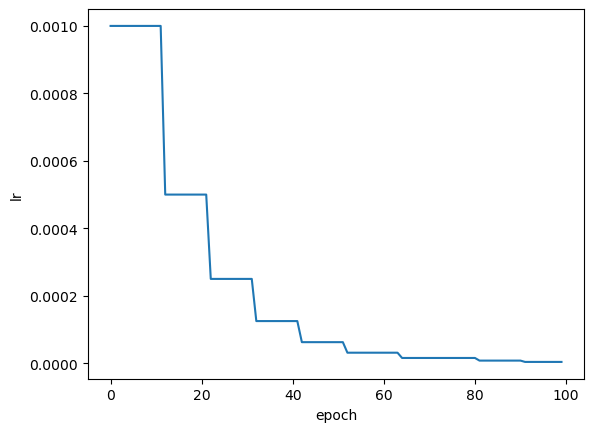

In [13]:
if INTERACTIVE_SESSION:
    show_convergence(train_history.history, 'lr')

### Evaluate and Vizualize

In [14]:
print("\n\n{}\n\t{}\n{}".format('='*55,f'Evaluate {m_obj.Name} model', '-'*55))
start = time.time()
y_pred = model.predict(x_test)

start = time.time() - start
print("evaluation elapsed time:___{:5.2f}___minutes" \
                .format(start/60))




	Evaluate unet model
-------------------------------------------------------


2024-05-31 18:18:03.782548: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907



   1/7004 [..............................] - ETA: 16:52:54


  12/7004 [..............................] - ETA: 32s     


  22/7004 [..............................] - ETA: 35s


  33/7004 [..............................] - ETA: 35s


  42/7004 [..............................] - ETA: 36s


  53/7004 [..............................] - ETA: 35s


  64/7004 [..............................] - ETA: 34s


  75/7004 [..............................] - ETA: 34s


  86/7004 [..............................] - ETA: 34s


  97/7004 [..............................] - ETA: 34s


 107/7004 [..............................] - ETA: 34s


 114/7004 [..............................] - ETA: 35s


 125/7004 [..............................] - ETA: 35s


 135/7004 [..............................] - ETA: 35s


 145/7004 [..............................] - ETA: 35s


 156/7004 [..............................] - ETA: 35s


 168/7004 [..............................] - ETA: 34s


 177/7004 [..............................] - ETA: 34s


 188/7004 [..............................] - ETA: 34s


 198/7004 [..............................] - ETA: 34s


 208/7004 [..............................] - ETA: 34s


 216/7004 [..............................] - ETA: 35s


 229/7004 [..............................] - ETA: 34s


 240/7004 [>.............................] - ETA: 34s


 249/7004 [>.............................] - ETA: 34s


 259/7004 [>.............................] - ETA: 34s


 269/7004 [>.............................] - ETA: 34s


 278/7004 [>.............................] - ETA: 34s


 288/7004 [>.............................] - ETA: 34s


 297/7004 [>.............................] - ETA: 34s


 307/7004 [>.............................] - ETA: 34s


 316/7004 [>.............................] - ETA: 35s


 323/7004 [>.............................] - ETA: 35s


 336/7004 [>.............................] - ETA: 35s


 346/7004 [>.............................] - ETA: 34s


 355/7004 [>.............................] - ETA: 35s


 365/7004 [>.............................] - ETA: 35s


 374/7004 [>.............................] - ETA: 35s


 384/7004 [>.............................] - ETA: 35s


 393/7004 [>.............................] - ETA: 35s


 402/7004 [>.............................] - ETA: 35s


 411/7004 [>.............................] - ETA: 35s


 420/7004 [>.............................] - ETA: 35s


 426/7004 [>.............................] - ETA: 35s


 438/7004 [>.............................] - ETA: 35s


 447/7004 [>.............................] - ETA: 35s


 457/7004 [>.............................] - ETA: 35s


 466/7004 [>.............................] - ETA: 35s


 475/7004 [=>............................] - ETA: 35s


 484/7004 [=>............................] - ETA: 35s


 493/7004 [=>............................] - ETA: 35s


 502/7004 [=>............................] - ETA: 35s


 512/7004 [=>............................] - ETA: 35s


 523/7004 [=>............................] - ETA: 35s


 532/7004 [=>............................] - ETA: 35s


 546/7004 [=>............................] - ETA: 34s


 556/7004 [=>............................] - ETA: 34s


 565/7004 [=>............................] - ETA: 34s


 575/7004 [=>............................] - ETA: 34s


 584/7004 [=>............................] - ETA: 34s


 593/7004 [=>............................] - ETA: 34s


 604/7004 [=>............................] - ETA: 34s


 613/7004 [=>............................] - ETA: 34s


 623/7004 [=>............................] - ETA: 34s


 633/7004 [=>............................] - ETA: 34s


 639/7004 [=>............................] - ETA: 34s


 648/7004 [=>............................] - ETA: 34s


 658/7004 [=>............................] - ETA: 34s


 667/7004 [=>............................] - ETA: 34s


 676/7004 [=>............................] - ETA: 34s


 685/7004 [=>............................] - ETA: 34s


 695/7004 [=>............................] - ETA: 34s


 705/7004 [==>...........................] - ETA: 34s


 714/7004 [==>...........................] - ETA: 34s


 723/7004 [==>...........................] - ETA: 34s


 733/7004 [==>...........................] - ETA: 34s


 743/7004 [==>...........................] - ETA: 34s


 752/7004 [==>...........................] - ETA: 34s


 761/7004 [==>...........................] - ETA: 34s


 771/7004 [==>...........................] - ETA: 34s


 779/7004 [==>...........................] - ETA: 34s


 788/7004 [==>...........................] - ETA: 34s


 797/7004 [==>...........................] - ETA: 34s


 806/7004 [==>...........................] - ETA: 34s


 814/7004 [==>...........................] - ETA: 34s


 823/7004 [==>...........................] - ETA: 34s


 833/7004 [==>...........................] - ETA: 33s


 844/7004 [==>...........................] - ETA: 33s


 856/7004 [==>...........................] - ETA: 33s


 868/7004 [==>...........................] - ETA: 33s


 877/7004 [==>...........................] - ETA: 33s


 887/7004 [==>...........................] - ETA: 33s


 897/7004 [==>...........................] - ETA: 33s


 906/7004 [==>...........................] - ETA: 33s


 915/7004 [==>...........................] - ETA: 33s


 924/7004 [==>...........................] - ETA: 33s


 934/7004 [===>..........................] - ETA: 33s


 943/7004 [===>..........................] - ETA: 33s


 953/7004 [===>..........................] - ETA: 33s


 961/7004 [===>..........................] - ETA: 33s


 972/7004 [===>..........................] - ETA: 33s


 982/7004 [===>..........................] - ETA: 32s


 992/7004 [===>..........................] - ETA: 32s


1004/7004 [===>..........................] - ETA: 32s


1014/7004 [===>..........................] - ETA: 32s


1023/7004 [===>..........................] - ETA: 32s


1032/7004 [===>..........................] - ETA: 32s


1041/7004 [===>..........................] - ETA: 32s


1049/7004 [===>..........................] - ETA: 32s


1060/7004 [===>..........................] - ETA: 32s


1068/7004 [===>..........................] - ETA: 32s


1080/7004 [===>..........................] - ETA: 32s


1090/7004 [===>..........................] - ETA: 32s


1100/7004 [===>..........................] - ETA: 32s


1111/7004 [===>..........................] - ETA: 32s


1122/7004 [===>..........................] - ETA: 32s


1132/7004 [===>..........................] - ETA: 31s


1141/7004 [===>..........................] - ETA: 31s


1150/7004 [===>..........................] - ETA: 31s


1160/7004 [===>..........................] - ETA: 31s


1169/7004 [====>.........................] - ETA: 31s


1175/7004 [====>.........................] - ETA: 31s


1188/7004 [====>.........................] - ETA: 31s


1198/7004 [====>.........................] - ETA: 31s


1207/7004 [====>.........................] - ETA: 31s


1217/7004 [====>.........................] - ETA: 31s


1226/7004 [====>.........................] - ETA: 31s


1234/7004 [====>.........................] - ETA: 31s


1242/7004 [====>.........................] - ETA: 31s


1251/7004 [====>.........................] - ETA: 31s


1260/7004 [====>.........................] - ETA: 31s


1269/7004 [====>.........................] - ETA: 31s


1278/7004 [====>.........................] - ETA: 31s


1284/7004 [====>.........................] - ETA: 31s


1295/7004 [====>.........................] - ETA: 31s


1304/7004 [====>.........................] - ETA: 31s


1314/7004 [====>.........................] - ETA: 31s


1324/7004 [====>.........................] - ETA: 31s


1333/7004 [====>.........................] - ETA: 31s


1343/7004 [====>.........................] - ETA: 31s


1352/7004 [====>.........................] - ETA: 31s


1361/7004 [====>.........................] - ETA: 30s


1372/7004 [====>.........................] - ETA: 30s


1382/7004 [====>.........................] - ETA: 30s


1390/7004 [====>.........................] - ETA: 30s


1403/7004 [=====>........................] - ETA: 30s


1414/7004 [=====>........................] - ETA: 30s


1423/7004 [=====>........................] - ETA: 30s


1432/7004 [=====>........................] - ETA: 30s


1441/7004 [=====>........................] - ETA: 30s


1450/7004 [=====>........................] - ETA: 30s


1459/7004 [=====>........................] - ETA: 30s


1468/7004 [=====>........................] - ETA: 30s


1477/7004 [=====>........................] - ETA: 30s


1486/7004 [=====>........................] - ETA: 30s


1496/7004 [=====>........................] - ETA: 30s


1509/7004 [=====>........................] - ETA: 30s


1520/7004 [=====>........................] - ETA: 30s


1529/7004 [=====>........................] - ETA: 30s


1538/7004 [=====>........................] - ETA: 29s


1548/7004 [=====>........................] - ETA: 29s


1557/7004 [=====>........................] - ETA: 29s


1568/7004 [=====>........................] - ETA: 29s


1578/7004 [=====>........................] - ETA: 29s


1588/7004 [=====>........................] - ETA: 29s


1599/7004 [=====>........................] - ETA: 29s


1609/7004 [=====>........................] - ETA: 29s


1621/7004 [=====>........................] - ETA: 29s


1630/7004 [=====>........................] - ETA: 29s


1639/7004 [======>.......................] - ETA: 29s


1649/7004 [======>.......................] - ETA: 29s


1659/7004 [======>.......................] - ETA: 29s


1668/7004 [======>.......................] - ETA: 29s


1678/7004 [======>.......................] - ETA: 29s


1688/7004 [======>.......................] - ETA: 29s


1698/7004 [======>.......................] - ETA: 29s


1708/7004 [======>.......................] - ETA: 28s


1715/7004 [======>.......................] - ETA: 29s


1728/7004 [======>.......................] - ETA: 28s


1737/7004 [======>.......................] - ETA: 28s


1747/7004 [======>.......................] - ETA: 28s


1757/7004 [======>.......................] - ETA: 28s


1767/7004 [======>.......................] - ETA: 28s


1778/7004 [======>.......................] - ETA: 28s


1788/7004 [======>.......................] - ETA: 28s


1798/7004 [======>.......................] - ETA: 28s


1807/7004 [======>.......................] - ETA: 28s


1816/7004 [======>.......................] - ETA: 28s


1825/7004 [======>.......................] - ETA: 28s


1838/7004 [======>.......................] - ETA: 28s


1847/7004 [======>.......................] - ETA: 28s


1856/7004 [======>.......................] - ETA: 28s


1868/7004 [=======>......................] - ETA: 28s


1879/7004 [=======>......................] - ETA: 27s


1889/7004 [=======>......................] - ETA: 27s


1898/7004 [=======>......................] - ETA: 27s


1907/7004 [=======>......................] - ETA: 27s


1916/7004 [=======>......................] - ETA: 27s


1925/7004 [=======>......................] - ETA: 27s


1932/7004 [=======>......................] - ETA: 27s


1945/7004 [=======>......................] - ETA: 27s


1955/7004 [=======>......................] - ETA: 27s


1964/7004 [=======>......................] - ETA: 27s


1973/7004 [=======>......................] - ETA: 27s


1982/7004 [=======>......................] - ETA: 27s


1991/7004 [=======>......................] - ETA: 27s


2001/7004 [=======>......................] - ETA: 27s


2010/7004 [=======>......................] - ETA: 27s


2020/7004 [=======>......................] - ETA: 27s


2029/7004 [=======>......................] - ETA: 27s


2039/7004 [=======>......................] - ETA: 27s


2052/7004 [=======>......................] - ETA: 27s


2063/7004 [=======>......................] - ETA: 27s


2073/7004 [=======>......................] - ETA: 26s


2083/7004 [=======>......................] - ETA: 26s


2093/7004 [=======>......................] - ETA: 26s


2103/7004 [========>.....................] - ETA: 26s


2113/7004 [========>.....................] - ETA: 26s


2124/7004 [========>.....................] - ETA: 26s


2134/7004 [========>.....................] - ETA: 26s


2143/7004 [========>.....................] - ETA: 26s


2154/7004 [========>.....................] - ETA: 26s


2166/7004 [========>.....................] - ETA: 26s


2177/7004 [========>.....................] - ETA: 26s


2188/7004 [========>.....................] - ETA: 26s


2199/7004 [========>.....................] - ETA: 26s


2209/7004 [========>.....................] - ETA: 26s


2219/7004 [========>.....................] - ETA: 26s


2229/7004 [========>.....................] - ETA: 26s


2239/7004 [========>.....................] - ETA: 25s


2249/7004 [========>.....................] - ETA: 25s


2258/7004 [========>.....................] - ETA: 25s


2266/7004 [========>.....................] - ETA: 25s


2278/7004 [========>.....................] - ETA: 25s


2287/7004 [========>.....................] - ETA: 25s


2295/7004 [========>.....................] - ETA: 25s


2304/7004 [========>.....................] - ETA: 25s


2314/7004 [========>.....................] - ETA: 25s


2322/7004 [========>.....................] - ETA: 25s


2332/7004 [========>.....................] - ETA: 25s


2342/7004 [=========>....................] - ETA: 25s


2351/7004 [=========>....................] - ETA: 25s


2361/7004 [=========>....................] - ETA: 25s


2371/7004 [=========>....................] - ETA: 25s


2377/7004 [=========>....................] - ETA: 25s


2387/7004 [=========>....................] - ETA: 25s


2398/7004 [=========>....................] - ETA: 25s


2407/7004 [=========>....................] - ETA: 25s


2417/7004 [=========>....................] - ETA: 25s


2427/7004 [=========>....................] - ETA: 24s


2436/7004 [=========>....................] - ETA: 24s


2445/7004 [=========>....................] - ETA: 24s


2454/7004 [=========>....................] - ETA: 24s


2464/7004 [=========>....................] - ETA: 24s


2474/7004 [=========>....................] - ETA: 24s


2480/7004 [=========>....................] - ETA: 24s


2493/7004 [=========>....................] - ETA: 24s


2503/7004 [=========>....................] - ETA: 24s


2512/7004 [=========>....................] - ETA: 24s


2522/7004 [=========>....................] - ETA: 24s


2531/7004 [=========>....................] - ETA: 24s


2541/7004 [=========>....................] - ETA: 24s


2551/7004 [=========>....................] - ETA: 24s


2561/7004 [=========>....................] - ETA: 24s


2570/7004 [==========>...................] - ETA: 24s


2580/7004 [==========>...................] - ETA: 24s


2588/7004 [==========>...................] - ETA: 24s


2599/7004 [==========>...................] - ETA: 24s


2608/7004 [==========>...................] - ETA: 24s


2617/7004 [==========>...................] - ETA: 23s


2626/7004 [==========>...................] - ETA: 23s


2636/7004 [==========>...................] - ETA: 23s


2645/7004 [==========>...................] - ETA: 23s


2655/7004 [==========>...................] - ETA: 23s


2665/7004 [==========>...................] - ETA: 23s


2674/7004 [==========>...................] - ETA: 23s


2683/7004 [==========>...................] - ETA: 23s


2688/7004 [==========>...................] - ETA: 23s


2700/7004 [==========>...................] - ETA: 23s


2710/7004 [==========>...................] - ETA: 23s


2720/7004 [==========>...................] - ETA: 23s


2729/7004 [==========>...................] - ETA: 23s


2739/7004 [==========>...................] - ETA: 23s


2749/7004 [==========>...................] - ETA: 23s


2758/7004 [==========>...................] - ETA: 23s


2768/7004 [==========>...................] - ETA: 23s


2779/7004 [==========>...................] - ETA: 23s


2788/7004 [==========>...................] - ETA: 23s


2794/7004 [==========>...................] - ETA: 23s


2806/7004 [===========>..................] - ETA: 23s


2816/7004 [===========>..................] - ETA: 22s


2826/7004 [===========>..................] - ETA: 22s


2835/7004 [===========>..................] - ETA: 22s


2844/7004 [===========>..................] - ETA: 22s


2853/7004 [===========>..................] - ETA: 22s


2864/7004 [===========>..................] - ETA: 22s


2873/7004 [===========>..................] - ETA: 22s


2882/7004 [===========>..................] - ETA: 22s


2892/7004 [===========>..................] - ETA: 22s


2898/7004 [===========>..................] - ETA: 22s


2911/7004 [===========>..................] - ETA: 22s


2921/7004 [===========>..................] - ETA: 22s


2930/7004 [===========>..................] - ETA: 22s


2940/7004 [===========>..................] - ETA: 22s


2949/7004 [===========>..................] - ETA: 22s


2958/7004 [===========>..................] - ETA: 22s


2968/7004 [===========>..................] - ETA: 22s


2979/7004 [===========>..................] - ETA: 22s


2989/7004 [===========>..................] - ETA: 22s


2999/7004 [===========>..................] - ETA: 21s


3008/7004 [===========>..................] - ETA: 21s


3021/7004 [===========>..................] - ETA: 21s


3031/7004 [===========>..................] - ETA: 21s


3040/7004 [============>.................] - ETA: 21s


3049/7004 [============>.................] - ETA: 21s


3059/7004 [============>.................] - ETA: 21s


3069/7004 [============>.................] - ETA: 21s


3080/7004 [============>.................] - ETA: 21s


3090/7004 [============>.................] - ETA: 21s


3099/7004 [============>.................] - ETA: 21s


3109/7004 [============>.................] - ETA: 21s


3116/7004 [============>.................] - ETA: 21s


3129/7004 [============>.................] - ETA: 21s


3140/7004 [============>.................] - ETA: 21s


3150/7004 [============>.................] - ETA: 21s


3161/7004 [============>.................] - ETA: 21s


3172/7004 [============>.................] - ETA: 20s


3182/7004 [============>.................] - ETA: 20s


3191/7004 [============>.................] - ETA: 20s


3200/7004 [============>.................] - ETA: 20s


3209/7004 [============>.................] - ETA: 20s


3218/7004 [============>.................] - ETA: 20s


3229/7004 [============>.................] - ETA: 20s


3239/7004 [============>.................] - ETA: 20s


3250/7004 [============>.................] - ETA: 20s


3260/7004 [============>.................] - ETA: 20s


3270/7004 [=============>................] - ETA: 20s


3281/7004 [=============>................] - ETA: 20s


3290/7004 [=============>................] - ETA: 20s


3299/7004 [=============>................] - ETA: 20s


3309/7004 [=============>................] - ETA: 20s


3319/7004 [=============>................] - ETA: 20s


3329/7004 [=============>................] - ETA: 20s


3339/7004 [=============>................] - ETA: 20s


3345/7004 [=============>................] - ETA: 20s


3357/7004 [=============>................] - ETA: 19s


3367/7004 [=============>................] - ETA: 19s


3377/7004 [=============>................] - ETA: 19s


3387/7004 [=============>................] - ETA: 19s


3396/7004 [=============>................] - ETA: 19s


3405/7004 [=============>................] - ETA: 19s


3415/7004 [=============>................] - ETA: 19s


3425/7004 [=============>................] - ETA: 19s


3435/7004 [=============>................] - ETA: 19s


3445/7004 [=============>................] - ETA: 19s


3454/7004 [=============>................] - ETA: 19s


3460/7004 [=============>................] - ETA: 19s


3470/7004 [=============>................] - ETA: 19s


3480/7004 [=============>................] - ETA: 19s


3490/7004 [=============>................] - ETA: 19s


3499/7004 [=============>................] - ETA: 19s


3508/7004 [==============>...............] - ETA: 19s


3517/7004 [==============>...............] - ETA: 19s


3531/7004 [==============>...............] - ETA: 19s


3542/7004 [==============>...............] - ETA: 19s


3552/7004 [==============>...............] - ETA: 19s


3561/7004 [==============>...............] - ETA: 19s


3571/7004 [==============>...............] - ETA: 18s


3581/7004 [==============>...............] - ETA: 18s


3590/7004 [==============>...............] - ETA: 18s


3599/7004 [==============>...............] - ETA: 18s


3608/7004 [==============>...............] - ETA: 18s


3616/7004 [==============>...............] - ETA: 18s


3626/7004 [==============>...............] - ETA: 18s


3633/7004 [==============>...............] - ETA: 18s


3645/7004 [==============>...............] - ETA: 18s


3654/7004 [==============>...............] - ETA: 18s


3663/7004 [==============>...............] - ETA: 18s


3672/7004 [==============>...............] - ETA: 18s


3681/7004 [==============>...............] - ETA: 18s


3690/7004 [==============>...............] - ETA: 18s


3699/7004 [==============>...............] - ETA: 18s


3708/7004 [==============>...............] - ETA: 18s


3717/7004 [==============>...............] - ETA: 18s


3726/7004 [==============>...............] - ETA: 18s


3735/7004 [==============>...............] - ETA: 18s


3745/7004 [===============>..............] - ETA: 18s


3755/7004 [===============>..............] - ETA: 17s


3764/7004 [===============>..............] - ETA: 17s


3774/7004 [===============>..............] - ETA: 17s


3784/7004 [===============>..............] - ETA: 17s


3795/7004 [===============>..............] - ETA: 17s


3805/7004 [===============>..............] - ETA: 17s


3815/7004 [===============>..............] - ETA: 17s


3824/7004 [===============>..............] - ETA: 17s


3834/7004 [===============>..............] - ETA: 17s


3843/7004 [===============>..............] - ETA: 17s


3855/7004 [===============>..............] - ETA: 17s


3865/7004 [===============>..............] - ETA: 17s


3875/7004 [===============>..............] - ETA: 17s


3885/7004 [===============>..............] - ETA: 17s


3895/7004 [===============>..............] - ETA: 17s


3904/7004 [===============>..............] - ETA: 17s


3913/7004 [===============>..............] - ETA: 17s


3923/7004 [===============>..............] - ETA: 17s


3933/7004 [===============>..............] - ETA: 16s


3943/7004 [===============>..............] - ETA: 16s


3952/7004 [===============>..............] - ETA: 16s


3965/7004 [===============>..............] - ETA: 16s


3974/7004 [================>.............] - ETA: 16s


3985/7004 [================>.............] - ETA: 16s


3994/7004 [================>.............] - ETA: 16s


4003/7004 [================>.............] - ETA: 16s


4013/7004 [================>.............] - ETA: 16s


4023/7004 [================>.............] - ETA: 16s


4032/7004 [================>.............] - ETA: 16s


4041/7004 [================>.............] - ETA: 16s


4051/7004 [================>.............] - ETA: 16s


4059/7004 [================>.............] - ETA: 16s


4072/7004 [================>.............] - ETA: 16s


4082/7004 [================>.............] - ETA: 16s


4091/7004 [================>.............] - ETA: 16s


4100/7004 [================>.............] - ETA: 16s


4110/7004 [================>.............] - ETA: 16s


4119/7004 [================>.............] - ETA: 15s


4129/7004 [================>.............] - ETA: 15s


4138/7004 [================>.............] - ETA: 15s


4148/7004 [================>.............] - ETA: 15s


4158/7004 [================>.............] - ETA: 15s


4168/7004 [================>.............] - ETA: 15s


4175/7004 [================>.............] - ETA: 15s


4186/7004 [================>.............] - ETA: 15s


4194/7004 [================>.............] - ETA: 15s


4203/7004 [=================>............] - ETA: 15s


4213/7004 [=================>............] - ETA: 15s


4223/7004 [=================>............] - ETA: 15s


4233/7004 [=================>............] - ETA: 15s


4242/7004 [=================>............] - ETA: 15s


4252/7004 [=================>............] - ETA: 15s


4261/7004 [=================>............] - ETA: 15s


4271/7004 [=================>............] - ETA: 15s


4279/7004 [=================>............] - ETA: 15s


4292/7004 [=================>............] - ETA: 14s


4302/7004 [=================>............] - ETA: 14s


4311/7004 [=================>............] - ETA: 14s


4321/7004 [=================>............] - ETA: 14s


4330/7004 [=================>............] - ETA: 14s


4339/7004 [=================>............] - ETA: 14s


4348/7004 [=================>............] - ETA: 14s


4357/7004 [=================>............] - ETA: 14s


4368/7004 [=================>............] - ETA: 14s


4377/7004 [=================>............] - ETA: 14s


4384/7004 [=================>............] - ETA: 14s


4396/7004 [=================>............] - ETA: 14s


4407/7004 [=================>............] - ETA: 14s


4417/7004 [=================>............] - ETA: 14s


4429/7004 [=================>............] - ETA: 14s


4439/7004 [==================>...........] - ETA: 14s


4449/7004 [==================>...........] - ETA: 14s


4460/7004 [==================>...........] - ETA: 14s


4468/7004 [==================>...........] - ETA: 14s


4477/7004 [==================>...........] - ETA: 13s


4487/7004 [==================>...........] - ETA: 13s


4495/7004 [==================>...........] - ETA: 13s


4505/7004 [==================>...........] - ETA: 13s


4515/7004 [==================>...........] - ETA: 13s


4524/7004 [==================>...........] - ETA: 13s


4533/7004 [==================>...........] - ETA: 13s


4542/7004 [==================>...........] - ETA: 13s


4551/7004 [==================>...........] - ETA: 13s


4561/7004 [==================>...........] - ETA: 13s


4570/7004 [==================>...........] - ETA: 13s


4581/7004 [==================>...........] - ETA: 13s


4590/7004 [==================>...........] - ETA: 13s


4596/7004 [==================>...........] - ETA: 13s


4607/7004 [==================>...........] - ETA: 13s


4617/7004 [==================>...........] - ETA: 13s


4626/7004 [==================>...........] - ETA: 13s


4636/7004 [==================>...........] - ETA: 13s


4646/7004 [==================>...........] - ETA: 13s


4656/7004 [==================>...........] - ETA: 12s


4666/7004 [==================>...........] - ETA: 12s


4677/7004 [===================>..........] - ETA: 12s


4687/7004 [===================>..........] - ETA: 12s


4696/7004 [===================>..........] - ETA: 12s


4703/7004 [===================>..........] - ETA: 12s


4715/7004 [===================>..........] - ETA: 12s


4724/7004 [===================>..........] - ETA: 12s


4733/7004 [===================>..........] - ETA: 12s


4742/7004 [===================>..........] - ETA: 12s


4752/7004 [===================>..........] - ETA: 12s


4761/7004 [===================>..........] - ETA: 12s


4771/7004 [===================>..........] - ETA: 12s


4780/7004 [===================>..........] - ETA: 12s


4790/7004 [===================>..........] - ETA: 12s


4800/7004 [===================>..........] - ETA: 12s


4805/7004 [===================>..........] - ETA: 12s


4815/7004 [===================>..........] - ETA: 12s


4825/7004 [===================>..........] - ETA: 12s


4835/7004 [===================>..........] - ETA: 11s


4844/7004 [===================>..........] - ETA: 11s


4854/7004 [===================>..........] - ETA: 11s


4864/7004 [===================>..........] - ETA: 11s


4874/7004 [===================>..........] - ETA: 11s


4883/7004 [===================>..........] - ETA: 11s


4893/7004 [===================>..........] - ETA: 11s


4904/7004 [====================>.........] - ETA: 11s


4914/7004 [====================>.........] - ETA: 11s


4922/7004 [====================>.........] - ETA: 11s


4933/7004 [====================>.........] - ETA: 11s


4944/7004 [====================>.........] - ETA: 11s


4955/7004 [====================>.........] - ETA: 11s


4966/7004 [====================>.........] - ETA: 11s


4976/7004 [====================>.........] - ETA: 11s


4985/7004 [====================>.........] - ETA: 11s


4994/7004 [====================>.........] - ETA: 11s


5004/7004 [====================>.........] - ETA: 11s


5014/7004 [====================>.........] - ETA: 10s


5023/7004 [====================>.........] - ETA: 10s


5029/7004 [====================>.........] - ETA: 10s


5041/7004 [====================>.........] - ETA: 10s


5051/7004 [====================>.........] - ETA: 10s


5061/7004 [====================>.........] - ETA: 10s


5071/7004 [====================>.........] - ETA: 10s


5080/7004 [====================>.........] - ETA: 10s


5091/7004 [====================>.........] - ETA: 10s


5102/7004 [====================>.........] - ETA: 10s


5113/7004 [====================>.........] - ETA: 10s


5124/7004 [====================>.........] - ETA: 10s


5134/7004 [====================>.........] - ETA: 10s


5143/7004 [=====================>........] - ETA: 10s


5152/7004 [=====================>........] - ETA: 10s


5163/7004 [=====================>........] - ETA: 10s


5172/7004 [=====================>........] - ETA: 10s


5181/7004 [=====================>........] - ETA: 10s


5191/7004 [=====================>........] - ETA: 9s 


5200/7004 [=====================>........] - ETA: 9s


5210/7004 [=====================>........] - ETA: 9s


5219/7004 [=====================>........] - ETA: 9s


5228/7004 [=====================>........] - ETA: 9s


5238/7004 [=====================>........] - ETA: 9s


5247/7004 [=====================>........] - ETA: 9s


5254/7004 [=====================>........] - ETA: 9s


5267/7004 [=====================>........] - ETA: 9s


5277/7004 [=====================>........] - ETA: 9s


5286/7004 [=====================>........] - ETA: 9s


5296/7004 [=====================>........] - ETA: 9s


5305/7004 [=====================>........] - ETA: 9s


5316/7004 [=====================>........] - ETA: 9s


5326/7004 [=====================>........] - ETA: 9s


5335/7004 [=====================>........] - ETA: 9s


5346/7004 [=====================>........] - ETA: 9s


5356/7004 [=====================>........] - ETA: 9s


5364/7004 [=====================>........] - ETA: 9s


5377/7004 [======================>.......] - ETA: 8s


5386/7004 [======================>.......] - ETA: 8s


5395/7004 [======================>.......] - ETA: 8s


5405/7004 [======================>.......] - ETA: 8s


5416/7004 [======================>.......] - ETA: 8s


5426/7004 [======================>.......] - ETA: 8s


5435/7004 [======================>.......] - ETA: 8s


5444/7004 [======================>.......] - ETA: 8s


5453/7004 [======================>.......] - ETA: 8s


5463/7004 [======================>.......] - ETA: 8s


5470/7004 [======================>.......] - ETA: 8s


5481/7004 [======================>.......] - ETA: 8s


5491/7004 [======================>.......] - ETA: 8s


5500/7004 [======================>.......] - ETA: 8s


5509/7004 [======================>.......] - ETA: 8s


5518/7004 [======================>.......] - ETA: 8s


5527/7004 [======================>.......] - ETA: 8s


5536/7004 [======================>.......] - ETA: 8s


5546/7004 [======================>.......] - ETA: 8s


5556/7004 [======================>.......] - ETA: 7s


5565/7004 [======================>.......] - ETA: 7s


5571/7004 [======================>.......] - ETA: 7s


5584/7004 [======================>.......] - ETA: 7s


5593/7004 [======================>.......] - ETA: 7s


5601/7004 [======================>.......] - ETA: 7s


5610/7004 [=======================>......] - ETA: 7s


5619/7004 [=======================>......] - ETA: 7s


5628/7004 [=======================>......] - ETA: 7s


5637/7004 [=======================>......] - ETA: 7s


5646/7004 [=======================>......] - ETA: 7s


5655/7004 [=======================>......] - ETA: 7s


5665/7004 [=======================>......] - ETA: 7s


5671/7004 [=======================>......] - ETA: 7s


5683/7004 [=======================>......] - ETA: 7s


5693/7004 [=======================>......] - ETA: 7s


5702/7004 [=======================>......] - ETA: 7s


5711/7004 [=======================>......] - ETA: 7s


5721/7004 [=======================>......] - ETA: 7s


5733/7004 [=======================>......] - ETA: 7s


5743/7004 [=======================>......] - ETA: 6s


5753/7004 [=======================>......] - ETA: 6s


5763/7004 [=======================>......] - ETA: 6s


5774/7004 [=======================>......] - ETA: 6s


5780/7004 [=======================>......] - ETA: 6s


5792/7004 [=======================>......] - ETA: 6s


5803/7004 [=======================>......] - ETA: 6s


5813/7004 [=======================>......] - ETA: 6s


5822/7004 [=======================>......] - ETA: 6s


5830/7004 [=======================>......] - ETA: 6s


5839/7004 [========================>.....] - ETA: 6s


5849/7004 [========================>.....] - ETA: 6s


5858/7004 [========================>.....] - ETA: 6s


5867/7004 [========================>.....] - ETA: 6s


5876/7004 [========================>.....] - ETA: 6s


5882/7004 [========================>.....] - ETA: 6s


5893/7004 [========================>.....] - ETA: 6s


5902/7004 [========================>.....] - ETA: 6s


5912/7004 [========================>.....] - ETA: 6s


5922/7004 [========================>.....] - ETA: 5s


5933/7004 [========================>.....] - ETA: 5s


5944/7004 [========================>.....] - ETA: 5s


5953/7004 [========================>.....] - ETA: 5s


5963/7004 [========================>.....] - ETA: 5s


5973/7004 [========================>.....] - ETA: 5s


5982/7004 [========================>.....] - ETA: 5s


5989/7004 [========================>.....] - ETA: 5s


6001/7004 [========================>.....] - ETA: 5s


6010/7004 [========================>.....] - ETA: 5s


6018/7004 [========================>.....] - ETA: 5s


6027/7004 [========================>.....] - ETA: 5s


6038/7004 [========================>.....] - ETA: 5s


6047/7004 [========================>.....] - ETA: 5s


6056/7004 [========================>.....] - ETA: 5s


6067/7004 [========================>.....] - ETA: 5s


6076/7004 [=========================>....] - ETA: 5s


6084/7004 [=========================>....] - ETA: 5s


6093/7004 [=========================>....] - ETA: 5s


6099/7004 [=========================>....] - ETA: 4s


6111/7004 [=========================>....] - ETA: 4s


6121/7004 [=========================>....] - ETA: 4s


6132/7004 [=========================>....] - ETA: 4s


6141/7004 [=========================>....] - ETA: 4s


6152/7004 [=========================>....] - ETA: 4s


6161/7004 [=========================>....] - ETA: 4s


6170/7004 [=========================>....] - ETA: 4s


6179/7004 [=========================>....] - ETA: 4s


6189/7004 [=========================>....] - ETA: 4s


6198/7004 [=========================>....] - ETA: 4s


6203/7004 [=========================>....] - ETA: 4s


6214/7004 [=========================>....] - ETA: 4s


6223/7004 [=========================>....] - ETA: 4s


6234/7004 [=========================>....] - ETA: 4s


6245/7004 [=========================>....] - ETA: 4s


6256/7004 [=========================>....] - ETA: 4s


6267/7004 [=========================>....] - ETA: 4s


6278/7004 [=========================>....] - ETA: 4s


6288/7004 [=========================>....] - ETA: 3s


6299/7004 [=========================>....] - ETA: 3s


6310/7004 [==========================>...] - ETA: 3s


6317/7004 [==========================>...] - ETA: 3s


6329/7004 [==========================>...] - ETA: 3s


6339/7004 [==========================>...] - ETA: 3s


6349/7004 [==========================>...] - ETA: 3s


6359/7004 [==========================>...] - ETA: 3s


6368/7004 [==========================>...] - ETA: 3s


6377/7004 [==========================>...] - ETA: 3s


6386/7004 [==========================>...] - ETA: 3s


6396/7004 [==========================>...] - ETA: 3s


6406/7004 [==========================>...] - ETA: 3s


6415/7004 [==========================>...] - ETA: 3s


6425/7004 [==========================>...] - ETA: 3s


6435/7004 [==========================>...] - ETA: 3s


6447/7004 [==========================>...] - ETA: 3s


6457/7004 [==========================>...] - ETA: 3s


6466/7004 [==========================>...] - ETA: 2s


6474/7004 [==========================>...] - ETA: 2s


6483/7004 [==========================>...] - ETA: 2s


6492/7004 [==========================>...] - ETA: 2s


6501/7004 [==========================>...] - ETA: 2s


6510/7004 [==========================>...] - ETA: 2s


6519/7004 [==========================>...] - ETA: 2s


6529/7004 [==========================>...] - ETA: 2s


6537/7004 [==========================>...] - ETA: 2s


6550/7004 [===========================>..] - ETA: 2s


6559/7004 [===========================>..] - ETA: 2s


6568/7004 [===========================>..] - ETA: 2s


6578/7004 [===========================>..] - ETA: 2s


6588/7004 [===========================>..] - ETA: 2s


6598/7004 [===========================>..] - ETA: 2s


6607/7004 [===========================>..] - ETA: 2s


6617/7004 [===========================>..] - ETA: 2s


6626/7004 [===========================>..] - ETA: 2s


6635/7004 [===========================>..] - ETA: 2s


6642/7004 [===========================>..] - ETA: 1s


6651/7004 [===========================>..] - ETA: 1s


6662/7004 [===========================>..] - ETA: 1s


6672/7004 [===========================>..] - ETA: 1s


6681/7004 [===========================>..] - ETA: 1s


6690/7004 [===========================>..] - ETA: 1s


6699/7004 [===========================>..] - ETA: 1s


6708/7004 [===========================>..] - ETA: 1s


6718/7004 [===========================>..] - ETA: 1s


6727/7004 [===========================>..] - ETA: 1s


6735/7004 [===========================>..] - ETA: 1s


6745/7004 [===========================>..] - ETA: 1s


6755/7004 [===========================>..] - ETA: 1s


6760/7004 [===========================>..] - ETA: 1s


6771/7004 [============================>.] - ETA: 1s


6781/7004 [============================>.] - ETA: 1s


6790/7004 [============================>.] - ETA: 1s


6799/7004 [============================>.] - ETA: 1s


6808/7004 [============================>.] - ETA: 1s


6817/7004 [============================>.] - ETA: 1s


6827/7004 [============================>.] - ETA: 0s


6837/7004 [============================>.] - ETA: 0s


6847/7004 [============================>.] - ETA: 0s


6858/7004 [============================>.] - ETA: 0s


6863/7004 [============================>.] - ETA: 0s


6876/7004 [============================>.] - ETA: 0s


6887/7004 [============================>.] - ETA: 0s


6898/7004 [============================>.] - ETA: 0s


6909/7004 [============================>.] - ETA: 0s


6920/7004 [============================>.] - ETA: 0s


6929/7004 [============================>.] - ETA: 0s


6939/7004 [============================>.] - ETA: 0s


6949/7004 [============================>.] - ETA: 0s


6958/7004 [============================>.] - ETA: 0s


6967/7004 [============================>.] - ETA: 0s


6974/7004 [============================>.] - ETA: 0s


6986/7004 [============================>.] - ETA: 0s


6995/7004 [============================>.] - ETA: 0s


7004/7004 [==============================] - ETA: 0s


7004/7004 [==============================] - 48s 6ms/step


evaluation elapsed time:___ 1.21___minutes


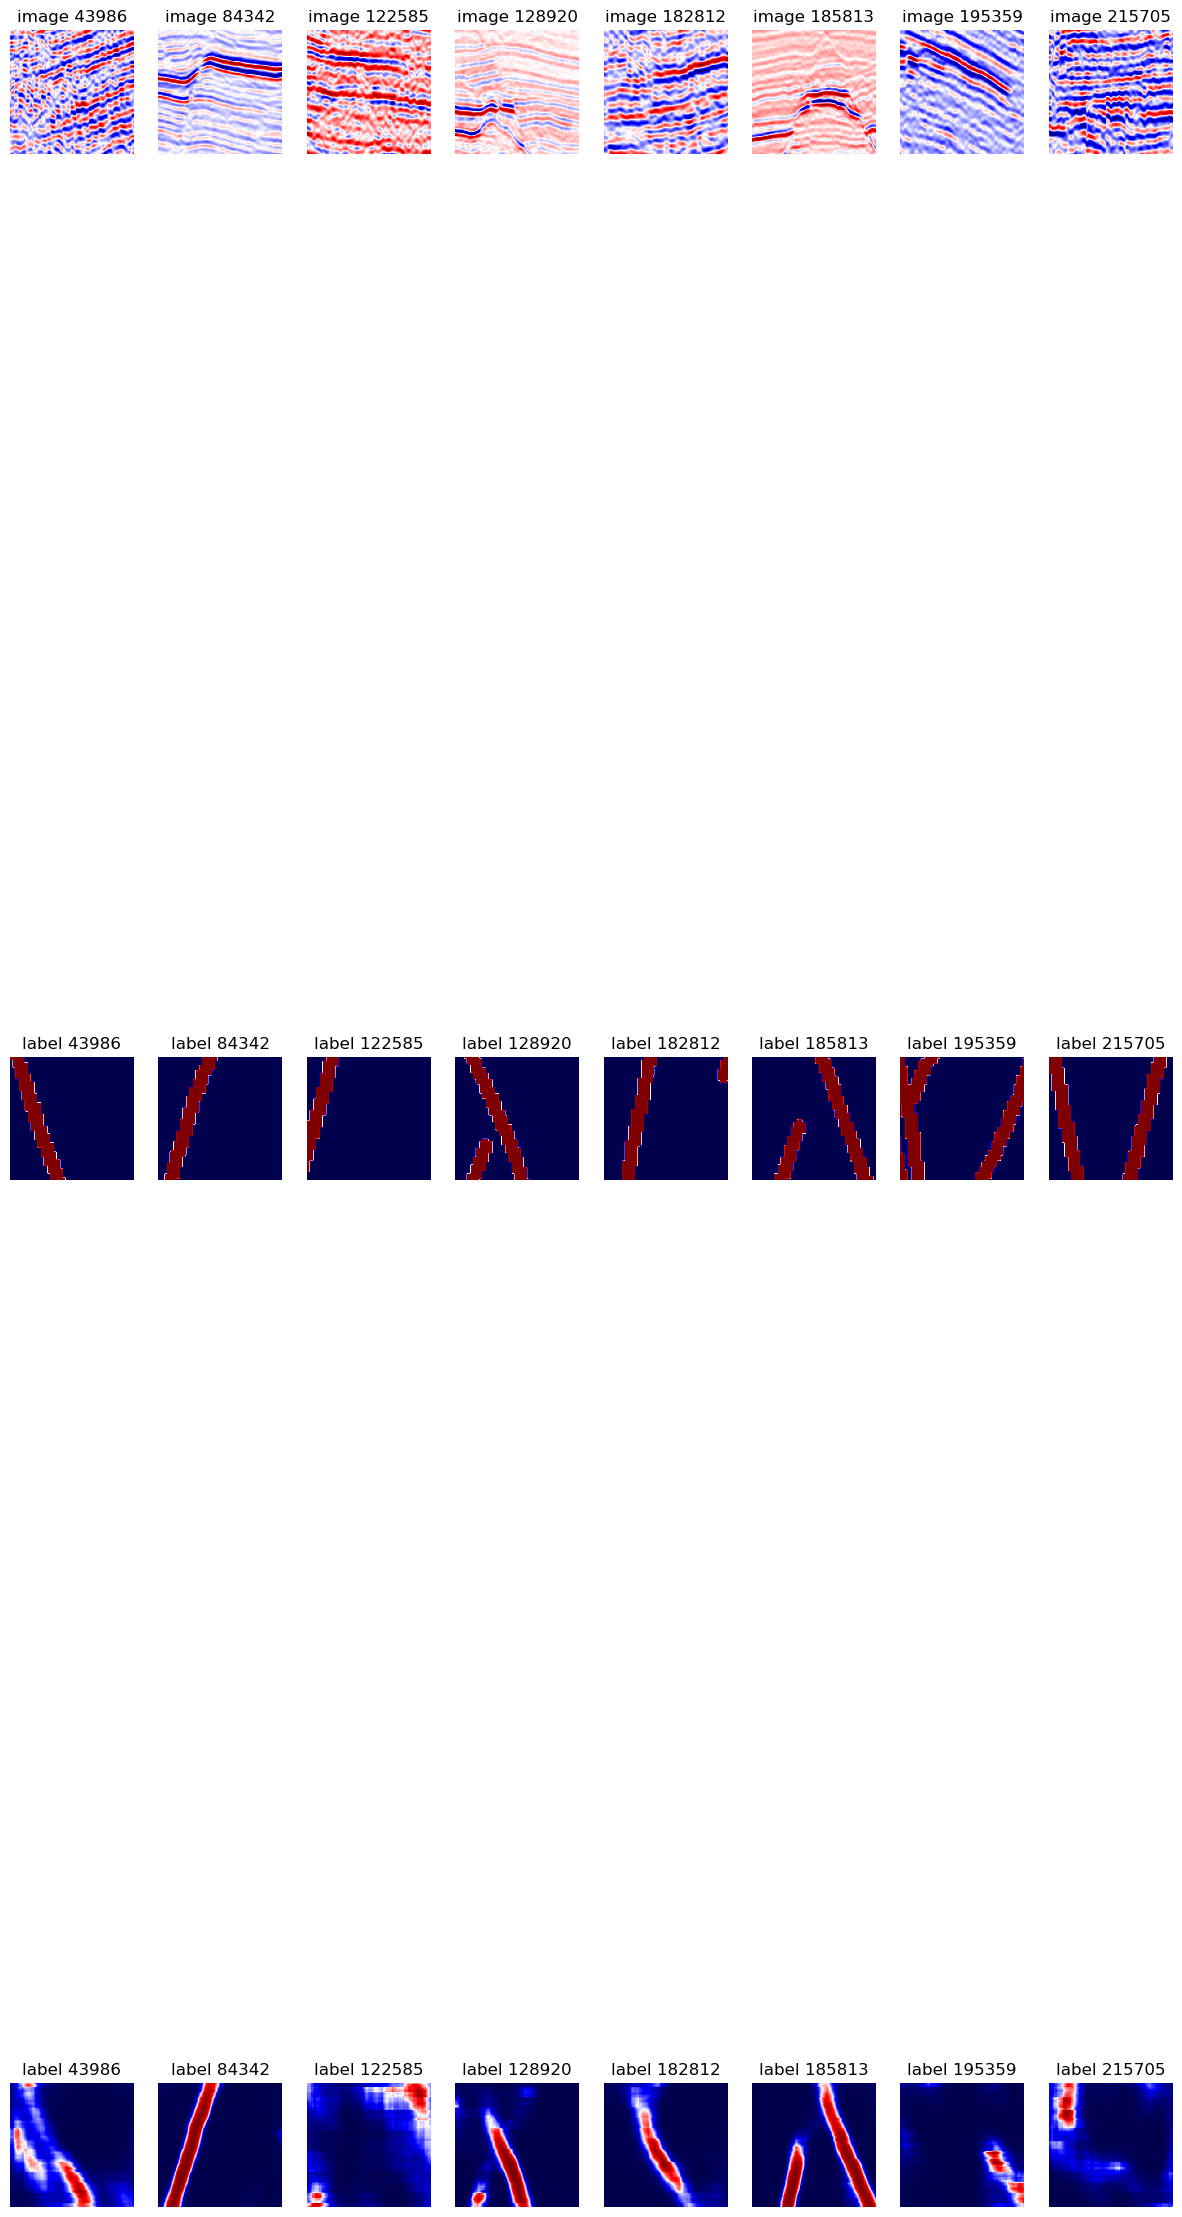

In [15]:

if INTERACTIVE_SESSION:
    seis.display_sample_images(x_test, y_test, y_pred)
    

In [16]:

scores = conf.evaluate_sklearn(y_test, y_pred,report=True)
print(scores)

evaluation elapsed time:___174.90___minutes
                      0             1  accuracy     macro avg  weighted avg
precision  9.300000e-01  7.200000e-01      0.92  8.200000e-01  9.100000e-01
recall     9.800000e-01  3.700000e-01      0.92  6.800000e-01  9.200000e-01
f1-score   9.500000e-01  4.900000e-01      0.92  7.200000e-01  9.000000e-01
support    1.841265e+09  2.242436e+08      0.92  2.065508e+09  2.065508e+09
{'Avg-precision': 0.58, 'f1-score(ODS)': 0.49}
